# Sentiment Analysis using DistilBERT on Yelp Reviews

## 1. Setup and Installations

In [1]:
%pip install datasets transformers torch evaluate optuna 'ray[tune]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 2. Import Libraries

In [2]:
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate # Hugging Face's evaluate library
import optuna
import warnings

warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Load and Prepare Data

In [3]:
# Load the dataset
dataset_full = load_dataset("yelp_review_full")

# Define sentiment mapping function
def map_stars_to_sentiment(label):
    if label in [0, 1]:  # Labels 0 and 1 are Negative (map to 0)
        return 0
    elif label == 2:  # Label 2 is Neutral (map to 1)
        return 1
    elif label in [3, 4]:  # Labels 3 and 4 are Positive (map to 2)
        return 2

# Convert to Pandas DataFrames and apply mapping
train_df_full = dataset_full['train'].to_pandas()
test_df_full = dataset_full['test'].to_pandas()

train_df_full['label'] = train_df_full['label'].apply(map_stars_to_sentiment)
test_df_full['label'] = test_df_full['label'].apply(map_stars_to_sentiment)

# --- Data Sampling (as in the original notebook) ---
# Sample 50,000 from the training data
train_sample = train_df_full.sample(n=50000, random_state=42).reset_index(drop=True)

# Split into train (90%) and validation (10%)
train_split = train_sample.sample(frac=0.9, random_state=42).reset_index(drop=True)
val_split = train_sample.drop(train_split.index).reset_index(drop=True)

# Sample 25,000 from the test data
test_split = test_df_full.sample(n=25000, random_state=42).reset_index(drop=True)

# Convert back to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_split)
val_dataset = Dataset.from_pandas(val_split)
test_dataset = Dataset.from_pandas(test_split)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print("Sampled Dataset Structure:")
print(dataset)

# Verify labels
unique_labels_train = set(dataset['train']['label'])
print(f"Unique labels in training set: {unique_labels_train}")
num_labels = len(unique_labels_train)
print(f"Number of labels: {num_labels}")

README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Sampled Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 45000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 25000
    })
})
Unique labels in training set: {0, 1, 2}
Number of labels: 3


## 4. Tokenization

In [4]:
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256) # Adjust max_length if needed

# Apply tokenization to all datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove the original 'text' column as it's no longer needed
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
# Rename 'label' to 'labels' for the Trainer
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
# Set format to PyTorch tensors
tokenized_datasets.set_format('torch')

print("\nTokenized Dataset Structure:")
print(tokenized_datasets)
print("\nExample tokenized input:")
print(tokenized_datasets['train'][0])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]


Tokenized Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 45000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

Example tokenized input:
{'labels': tensor(0), 'input_ids': tensor([  101,  6160,  2000,  1996, 10301,  1997,  6187,  3597,  2239,  1010,
         2214,  2111,  7249,  1010,  3788,  2757,  1012,  2123,  1005,  1056,
         4133,  1999,  1996,  2969, 10747,  2181,  2011,  1996, 22566,  2181,
         1012,  2017,  2024,  1996,  2197,  2000,  2131,  2326,  1010,  4064,
         7877,  1010, 13877,  5292,  7929,  2052,  2031,  2042,  3835,  2000,
         2156,  2014,  2062,  2059,  2320,  1012,  1032, 23961,  4819,  5705,
         2005,  5026,  2026, 15174,  2041,  2044,  1045,  2736,  2026,  6763,
    

## 5. Model Definition and Metrics

---



Model Definition

In [5]:
import torch
import torch.nn as nn
from transformers import DistilBertModel
class DistilBERTSentimentModel(nn.Module):
    def __init__(self, num_classes=3, dropout=0.3, pretrained_model='distilbert-base-uncased'):
        super(DistilBERTSentimentModel, self).__init__()
        self.bert = DistilBertModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


Evaluation Metrics

In [6]:
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}


# 6.Hyperparameter tuning

In [7]:
from transformers import TrainingArguments

training_args_hpt = TrainingArguments(
    output_dir="./results_hpt",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs_hpt",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    logging_strategy="epoch"
)


In [8]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "optimizer": trial.suggest_categorical("optimizer", ["adamw", "adam"]),
        "dropout": trial.suggest_float("dropout", 0.1, 0.5),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
         "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.01)
    }


In [9]:
def model_init(trial=None):
    dropout = trial.suggest_float("dropout", 0.1, 0.5) if trial else 0.3
    return DistilBERTSentimentModel(
        num_classes=num_labels,
        dropout=dropout,
        pretrained_model='distilbert-base-uncased'
    ).to(device)


In [10]:
import numpy as np

# Assume tokenized_datasets["train"] exists
train_dataset_size = len(tokenized_datasets["train"])
hpt_sample_size = int(0.15 * train_dataset_size)  # Use 15% of training data
np.random.seed(42)  # For reproducibility
train_indices_hpt = np.random.choice(train_dataset_size, hpt_sample_size, replace=False)

print(f"Using {hpt_sample_size} samples for hyperparameter tuning.")


Using 6750 samples for hyperparameter tuning.


In [11]:
from transformers import Trainer
from functools import partial

trainer_hpt = Trainer(
    model_init=partial(model_init),
    args=training_args_hpt,
    train_dataset=tokenized_datasets["train"].select(train_indices_hpt),
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [12]:
best_run = trainer_hpt.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=5,
    compute_objective=lambda metrics: metrics["eval_accuracy"]
)

best_params = best_run.hyperparameters
print("Best Hyperparameters:", best_params)


[I 2025-04-14 01:47:41,179] A new study created in memory with name: no-name-28fc32ab-c762-4ab5-bb7b-8c2eca318000
Trying to set optimizer in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dropout in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


[I 2025-04-14 01:49:57,423] Trial 0 finished with value: 0.7628 and parameters: {'learning_rate': 3.403181932815322e-06, 'optimizer': 'adam', 'dropout': 0.2696511556126312, 'per_device_train_batch_size': 16, 'weight_decay': 0.007589631489292307}. Best is trial 0 with value: 0.7628.
Trying to set optimizer in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dropout in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


[I 2025-04-14 01:52:03,382] Trial 1 finished with value: 0.768 and parameters: {'learning_rate': 5.9679391776481015e-06, 'optimizer': 'adam', 'dropout': 0.3823088776485072, 'per_device_train_batch_size': 32, 'weight_decay': 0.002776085600197088}. Best is trial 1 with value: 0.768.
Trying to set optimizer in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dropout in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


[I 2025-04-14 01:54:17,903] Trial 2 finished with value: 0.7966 and parameters: {'learning_rate': 4.4570370715858756e-05, 'optimizer': 'adamw', 'dropout': 0.127321411698607, 'per_device_train_batch_size': 16, 'weight_decay': 0.008458689198442167}. Best is trial 2 with value: 0.7966.
Trying to set optimizer in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dropout in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


[I 2025-04-14 01:56:23,232] Trial 3 finished with value: 0.7604 and parameters: {'learning_rate': 3.7074281063432927e-06, 'optimizer': 'adam', 'dropout': 0.14258637243942174, 'per_device_train_batch_size': 32, 'weight_decay': 0.004166994026648703}. Best is trial 2 with value: 0.7966.
Trying to set optimizer in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dropout in the hyperparameter search but there is no corresponding field in `TrainingArguments`.


[I 2025-04-14 01:58:37,409] Trial 4 finished with value: 0.7692 and parameters: {'learning_rate': 4.585821573371744e-06, 'optimizer': 'adam', 'dropout': 0.20466202186606247, 'per_device_train_batch_size': 16, 'weight_decay': 0.005649964244010724}. Best is trial 2 with value: 0.7966.


Best Hyperparameters: {'learning_rate': 4.4570370715858756e-05, 'optimizer': 'adamw', 'dropout': 0.127321411698607, 'per_device_train_batch_size': 16, 'weight_decay': 0.008458689198442167}


In [13]:
best_params

{'learning_rate': 4.4570370715858756e-05,
 'optimizer': 'adamw',
 'dropout': 0.127321411698607,
 'per_device_train_batch_size': 16,
 'weight_decay': 0.008458689198442167}

# 7.Final model training with best hyperparameter

In [14]:
from transformers import TrainerCallback
from sklearn.metrics import accuracy_score
import torch

class TrainAccuracyCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, model=None, tokenizer=None, train_dataloader=None, **kwargs):
        if model is None or train_dataloader is None:
            return

        model.eval()
        device = args.device
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in train_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs["logits"] if isinstance(outputs, dict) else outputs
                preds = torch.argmax(logits, dim=-1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        print(f"\n[Epoch {int(state.epoch)}] Train Accuracy: {acc:.4f}")

        # Log to Trainer history for plotting
        state.log_history.append({
            "epoch": state.epoch,
            "train_accuracy": acc
        })


In [15]:
final_training_args = TrainingArguments(
    output_dir="./results_final",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    num_train_epochs=3,
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=best_params["weight_decay"],
    logging_dir="./logs_final",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)


final_model = DistilBERTSentimentModel(
    num_classes=num_labels,
    dropout=best_params["dropout"],
    pretrained_model='distilbert-base-uncased'
).to(device)

final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[TrainAccuracyCallback()]
)

final_trainer.train()



[Epoch 1] Train Accuracy: 0.8531

[Epoch 2] Train Accuracy: 0.9227

[Epoch 3] Train Accuracy: 0.9629


TrainOutput(global_step=8439, training_loss=0.37695303368955474, metrics={'train_runtime': 956.4025, 'train_samples_per_second': 141.154, 'train_steps_per_second': 8.824, 'total_flos': 0.0, 'train_loss': 0.37695303368955474, 'epoch': 3.0})

# 8.Visualization - Train and Validation Accuracy & Loss over Epcohs




In [18]:
import matplotlib.pyplot as plt

def plot_accuracy_loss_by_epoch(history):
    train_loss_by_epoch = {}
    val_loss_by_epoch = {}
    train_acc_by_epoch = {}
    val_acc_by_epoch = {}

    for log in history:
        if "epoch" in log:
            epoch = int(log["epoch"])
            if "loss" in log and "step" in log:
                train_loss_by_epoch[epoch] = log["loss"]
            if "eval_loss" in log:
                val_loss_by_epoch[epoch] = log["eval_loss"]
            if "train_accuracy" in log:
                train_acc_by_epoch[epoch] = log["train_accuracy"]
            if "eval_accuracy" in log:
                val_acc_by_epoch[epoch] = log["eval_accuracy"]

    # Unified epoch list
    epochs = sorted(set(
        train_loss_by_epoch.keys() |
        val_loss_by_epoch.keys() |
        train_acc_by_epoch.keys() |
        val_acc_by_epoch.keys()
    ))

    train_loss = [train_loss_by_epoch.get(e, None) for e in epochs]
    val_loss = [val_loss_by_epoch.get(e, None) for e in epochs]
    train_acc = [train_acc_by_epoch.get(e, None) for e in epochs]
    val_acc = [val_acc_by_epoch.get(e, None) for e in epochs]

    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Training Loss", marker='o')
    plt.plot(epochs, val_loss, label="Validation Loss", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Training Accuracy", marker='o')
    plt.plot(epochs, val_acc, label="Validation Accuracy", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


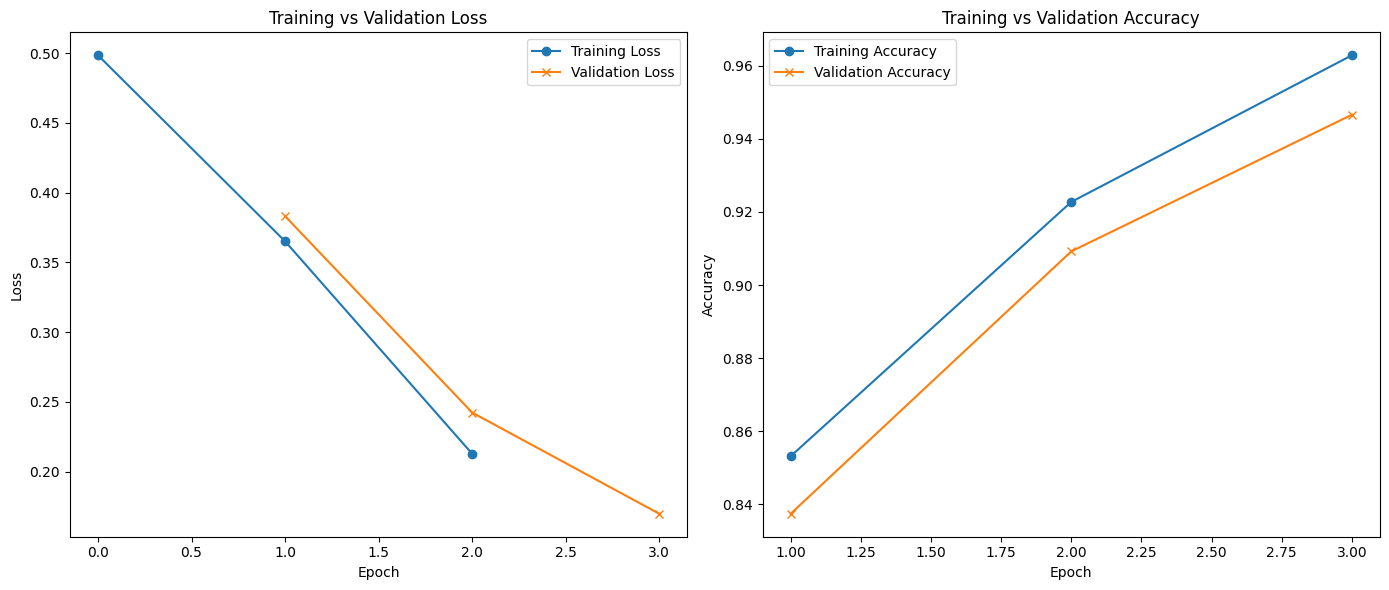

In [19]:
plot_accuracy_loss_by_epoch(final_trainer.state.log_history)

# 9.Saving model

In [20]:
final_trainer.save_model("./final_distilbert_model")
tokenizer.save_pretrained("./final_distilbert_model")


('./final_distilbert_model/tokenizer_config.json',
 './final_distilbert_model/special_tokens_map.json',
 './final_distilbert_model/vocab.txt',
 './final_distilbert_model/added_tokens.json',
 './final_distilbert_model/tokenizer.json')

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import os
drive_path = '/content/drive/My Drive/distilbert_models'
# If this file exists, delete it (torch checkpoint causes conflict)
pth_file = os.path.join(drive_path, "best_model.pth")
if os.path.exists(pth_file):
    os.remove(pth_file)


In [23]:
import os
# Define a path on Google Drive where you want to save the model
drive_path = '/content/drive/My Drive/distilbert_models'

# Create the folder if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Save the model to Google Drive
torch.save(final_model.state_dict(), f'{drive_path}/best_model.pth')



# 10.Evaluation on Test Data

Test Loss: 0.6395, Test Accuracy: 0.8074


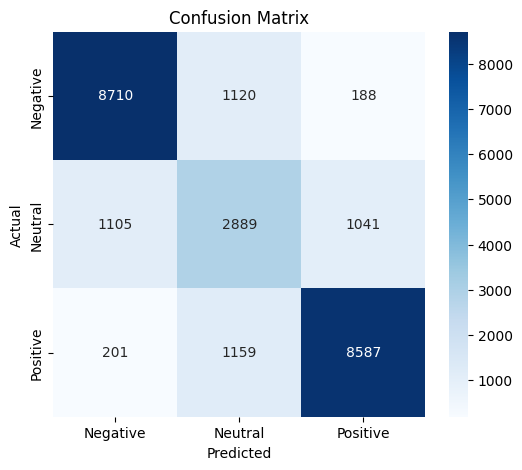

Classification Report:

              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87     10018
     Neutral       0.56      0.57      0.57      5035
    Positive       0.87      0.86      0.87      9947

    accuracy                           0.81     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.81      0.81      0.81     25000



In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Run predictions on the test set
test_predictions = final_trainer.predict(tokenized_datasets["test"])

# Extract predicted labels
y_pred = np.argmax(test_predictions.predictions, axis=1)
y_true = test_predictions.label_ids

# Calculate test loss and accuracy
test_loss = test_predictions.metrics["test_loss"]
test_accuracy = test_predictions.metrics["test_accuracy"]

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix and Classification Report
class_names = ['Negative', 'Neutral', 'Positive']

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def print_classification_report(y_true, y_pred, class_names):
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Visualize
plot_confusion_matrix(y_true, y_pred, class_names)
print_classification_report(y_true, y_pred, class_names)


In [25]:
!pip install shap


In [26]:
model = final_trainer.model  # Get trained model


# 11.LIME for interpretability and visualization

In [27]:
import torch
import numpy as np

# Ensure model is in eval mode and on correct device
model = final_trainer.model
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define your wrapper for LIME to call
def predict_proba(texts, batch_size=2):
    model.eval()
    probs_list = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=256)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            probs = torch.nn.functional.softmax(logits, dim=1)
            probs_list.append(probs.cpu().numpy())

        # Free up memory after each batch
        del input_ids, attention_mask, outputs, logits, probs
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

    return np.vstack(probs_list)



In [28]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [29]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0462ff5c57f2c27839bb690a0e47431e51377d665ae7d6c9335f030fb58708ed
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [30]:
from lime.lime_text import LimeTextExplainer

class_names = ['Negative', 'Neutral', 'Positive']
explainer = LimeTextExplainer(class_names=class_names)


In [31]:
text = "The food was amazing and the staff were super friendly!"
exp = explainer.explain_instance(text, predict_proba, num_features=10)
exp.show_in_notebook(text=text)

In [32]:
text = "Absolutely terrible experience. I’m never coming back."
exp = explainer.explain_instance(text, predict_proba, num_features=10)
exp.show_in_notebook(text=text)

In [33]:
text = "The food was not that bad."
exp = explainer.explain_instance(text, predict_proba, num_features=10)
exp.show_in_notebook(text=text)

In [34]:
from sklearn.metrics import accuracy_score, f1_score
import torch
import pandas as pd
from tqdm import tqdm

def evaluate_distilbert_by_length(
    model,
    tokenizer,
    dataset,
    device,
    max_len=256,
    batch_size=32
):
    model.eval()
    length_bins = [
        ((0, 50), "Short"),
        ((51, 100), "Medium"),
        ((101, 200), "Long"),
        ((201, 10000), "Very Long")
    ]

    results = []

    texts = [example['text'] for example in dataset]
    labels = [example['label'] for example in dataset]

    for (min_len, max_len_bin), label in length_bins:
        indices = [
            i for i, text in enumerate(texts)
            if min_len <= len(text.split()) <= max_len_bin
        ]
        if not indices:
            continue

        X_bin = [texts[i] for i in indices]
        y_bin = [labels[i] for i in indices]
        all_preds = []

        with torch.no_grad():
            for i in tqdm(range(0, len(X_bin), batch_size), desc=f"Evaluating {min_len}-{max_len_bin} words"):
                batch_texts = X_bin[i:i+batch_size]
                encoded = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
                input_ids = encoded["input_ids"].to(device)
                attention_mask = encoded["attention_mask"].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs["logits"]
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                all_preds.extend(preds)

                # Optional memory cleanup
                del input_ids, attention_mask, logits, outputs
                torch.cuda.empty_cache()

        acc = accuracy_score(y_bin, all_preds)
        f1 = f1_score(y_bin, all_preds, average='weighted')

        results.append({
            'Length Category': label,
            'Length Range': f"{min_len}-{max_len_bin}",
            'Accuracy': acc,
            'F1 Score': f1,
            'Sample Size': len(indices)
        })

        torch.cuda.empty_cache()

    return pd.DataFrame(results)


In [35]:
df_length_analysis = evaluate_distilbert_by_length(
    model=final_model,
    tokenizer=tokenizer,
    dataset=test_dataset,  # Should be a list of dicts with 'text' and 'label'
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

df_length_analysis


Evaluating 201-10000 words: 100%|██████████| 158/158 [00:09<00:00, 17.27it/s]


Length Category Length Range  Accuracy  F1 Score  Sample Size
0           Short         0-50  0.821483  0.821734         5893
1          Medium       51-100  0.823134  0.824129         6700
2            Long      101-200  0.811101  0.810836         7369
3       Very Long    201-10000  0.764788  0.767543         5038

In [36]:
import matplotlib.pyplot as plt

def plot_lime_token_importance(lime_exp):
    tokens, weights = zip(*lime_exp.as_list())
    plt.figure(figsize=(10, 4))
    plt.barh(tokens[::-1], weights[::-1], color='skyblue')
    plt.xlabel("Importance")
    plt.title("Token Influence (LIME)")
    plt.tight_layout()
    plt.show()


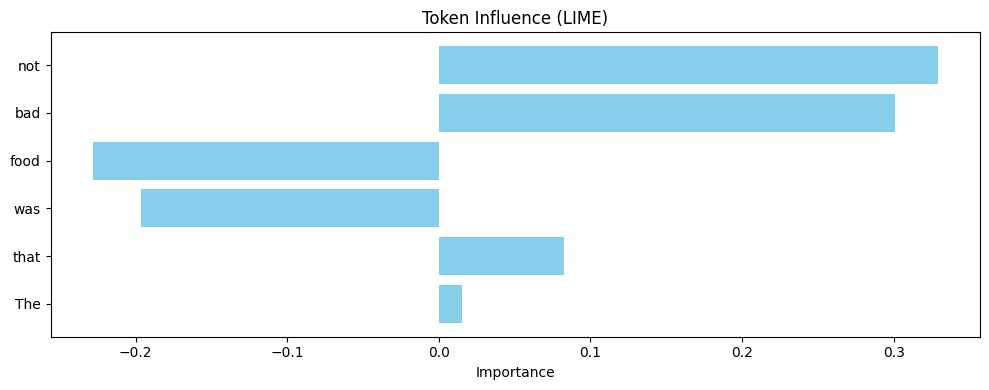

In [37]:
plot_lime_token_importance(exp)
